## Practical Exercise 1: An Introduction to Word Embeddings and Word2Vec

Before we start, we would like to highlight that each of the three notebooks will contribute equally to your final grade.

Submission Deadline: December 6th, 2024 at 23:59:00 (strict deadline)

This practical Exercise is presented as an IPython Notebook, with the code written for recent versions of **Python 3**.

Before working with this notebook, you need to execute some of the pre-coded cells (to load libraries/functions/modules etc.). To execute one notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Below is a list with potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

#### Introduction & imports

In this notebook you will familiarize yourselves with constructing and using word-embeddings. As you recall from the lecture, word-embeddings are a type of word representation that allow words with similar meaning to have similar representations. This can be achieved by representing words as real-valued vectors in a predefined vector space. However, before delving into the embedding process, you will need to learn how to use some basic NLP tools like tokenization and regular expressions!
Good Luck and happy coding!

In [46]:
# Importing necessary libraries/modules; requires to be executed once for every session
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle
import re
import nltk
import inflect

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
nltk.download('punkt')

!%pip install wordcloud
from wordcloud import WordCloud

Loading BokehJS ...

/bin/bash: line 1: fg: no job control


[nltk_data] Downloading package punkt to /home/alec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
# Here we install nltk. You only have to execute this cell once!
try:
    import nltk
except:
    import sys
    !{sys.executable} -m pip install nltk+
    import nltk
    nltk.download()

### Part 0: Download the TED dataset

For this practical exercise, we need a large amount of text data. We will use the TED database, which are the transcripts of Ted Talks. The next cells will download everything you need, this might take a while as the dataset is 75MB large.

In [48]:
import zipfile
import lxml.etree

In [49]:
# # Upload the dataset if it's not already there: this may take a minute..
# if not os.path.isfile('ted_en-20160408.zip'):
#   from google.colab import files
#   # select the file "ted_en-20160408.zip" from your local drive here
#   uploaded = files.upload()

# The above should be uncommented if you are using google colab.

In [50]:
# This is used if the file is in the current workinig directory, which I have placed it in. 
if not os.path.isfile('ted_en-20160408.zip'):
    print("File 'ted_en-20160408.zip' is missing. Please download it manually or provide the correct path.")
else:
    print("File found! Ready to proceed.")


File found! Ready to proceed.


In [51]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z: # 'with' ensures that the file is properly closed after the block is executed. 'r' is read mode
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r')) # ElementTree object, allows traversal and querying of the XML structure.
input_text = '\n'.join(doc.xpath('//content/text()')) # XPath (//content/text()) to extract all text nodes under <content> elements in the XML.
                                                        # '\n'.join(), Joins all extracted text nodes into a single string, with each text node separated by a newline
print(type(input_text)) # input_text = plain text of the subtitles.

<class 'str'>


To give you a little bit of an idea about the structure of the dataset, you can open the `xml` file inside the zip folder and have a look at it. The dataset consists of metadata or properties of TedTalks, such as speaker information, language, transcripts, tags, date, and much more.

As you can see, the `xml` file has lots of different tags to mark the beginning and end of the particular datapoint. The code cell bellow shows the tags that are inside the `xml` file. As you can already imagine, the tags are used to mark different properties of the data. For this assignment, we are interested in the content/text only, which is the reason for extracting the text from the content tag and from it, create the text data.

In [52]:
# Extract all the tags in the XML
tags = [element.tag for element in doc.iter()]

# Get unique tags using a set
unique_tags = set(tags)

# Print the unique tags
for tag in unique_tags:
    print(tag)

# Delete the variable doc to save space as we have alreay extracted the necessary data we need.
del doc

description
head
charnum
encoding
dtime
content
translator
xml
speaker
content-type
reviewers
transcriber
transcribers
translators
url
file
date
videourl
talkid
wordnum
seekvideo
pagesize
reviewer
keywords
videopath
title
transcription


### Part 1: Preprocessing

Although language oftentimes follows strict rules and structures, text datasets in practice are often noisy. Before we can use our text data, we therefore need to clean it. This process is called *preprocessing*. If we don't do this, the data may be inconsistent and therefore more difficult to analyze and work with. You may ask yourself, what exactly do we need to clean, where exactly would we expect inconsistencies? Take a moment and think about it's potential hickups in the raw data. What we need to do, is to preprocess the text and bring it into a clean and consistent format, allowing further analyzing steps.

<h4>Exercise 1.1 (3 Points)</h4>



The following part of the code shows a chunk of text from our ted text dataset. Have a look and try to identify **three** issues you can think of that can create a problem for text analysis, next to the one which is already provided. When giving your answer, we ask you to also mention **why** the issues could be problematic (similar to the example given). Each correct answer (naming + explaining the problem) will give 1 point.

In [53]:
# Have a look at the output of this code, to see some text examples.
i = input_text.find("Hyowon Gweon: See this?") # extracts 300 characters of text starting from the location of "Hyowon Gweon: See this?"
print(input_text[i:i+300])
print()

i = input_text.find("You will earn")
print(input_text[i:i+45])

Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.
Laura Schulz: Told you. (Laughs)
(Video) HG: See this one? (Ball squeaks) Hey Clara, this one's for you. You can go ahead and play. (Laughter)
LS: I don't even have to talk, right? All rig

You will earn 10% of any gold you distributes


<b>Your Solution goes here:</b>
<br>- Speakers' names: embeddings for names will dominate the embedding space unnecessarily.

<br>- **Non-linguistic Noises** (e.g. "(Ball squeaks)"): Can create noise, if treated as meaningful text will lead to embeddings that include irrelevant information.

<br>-  **Number and Percentage symbols**: Percentage symbols (%) may skew embeddings if treated as text, leading to inconsistency. Numerical digits can distort embeddings unless normalized appropriately.

<br>- **Expanding contractions and removing apostrophes and white spaces**: . After the above preprocesing it is benificial to expand for exampe don't to do not. We should ensure that there are easily interpretable words that are spaced with one whitespace, therefore is is important to ensure sentences and words are correctly spaced with white spaces. There should be no two white spaces after another and there should always be one whitespace after a fullstop. This would make handeling the text less peoblematic.

<h4>Exercise 1.2 (9 Points)</h4>

Next we want to create a preprocessing pipeline to later clean the entire dataset in one go. The pipeline takes `input_text` as input and should provide a cleaned and ready-to-use text data called `cleaned_text`.

Your task is to implement this pipeline with **three** functions that each take care of **one** of the **three** issues you listed in exercise 1.1.

Some hints about the pipeline are given as well as the code for the example from 1.1.

In [54]:
# added code by me
print(len(input_text))

24222849


In [55]:
def remove_speaker(text):
  ''' takes the text as an input and removes the name of the speaker as output '''

  input_text = text

  X = []
  for line in input_text.split('\n'):
      #print(line)
      m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
      X.extend(m.groupdict()['postcolon'])
  without_speaker="".join(X)
  return without_speaker

## To Do ##
# implement your 3 functions.
# Make the name of the functions sensible.

# def ... my added code

# -- Function 1: Remove action words in brackets, including the brackets and a whitespace after the bracket. -- 
def remove_parenthetical_actions(text):
    """
    Removes text within parentheses, including the parentheses themselves.
    """
    return re.sub(r'\([^)]*\)', '', text)

# def ... my added code

# -- Function 2: Replace all percentage symbols with 'percent' and number to word/string-- 
def replace_percentage_and_numbers(text):
    """
    Replaces all % with the word 'percent' and replaces all numbers with their word equivalents.
    """
    # Initialize the inflect engine
    inf = inflect.engine()

    # Function to replace matched digits with words
    def replace_with_words(match):
        number = match.group()
        return inf.number_to_words(int(number))

    # Replace % with 'percent'
    text = re.sub(r'\%', ' percent', text)

    # Replace numbers with their word equivalents
    text = re.sub(r'\d+', replace_with_words, text)

    return text

# def ... my added code

# -- Function 3: Replace all contractions with their two words and deal with white spaces. -- 
import contractions

def replace_apostrophes_and_clean_whitespace(text):
    """
    Expands contractions, ensures a single space after every full stop,
    and removes extra whitespace.
    """
    # Step 1: Expand contractions
    text = contractions.fix(text)

    # Step 2: Ensure a single space after every full stop
    text = re.sub(r'\.(?!\s)', '. ', text)

    # Step 3: Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def text_cleaned(input_text):

  ''' takes the raw text as input. Runs the text through cleaning functions.
       outputs a clean and preprocessed text for further analysis. '''
  

  ## To Do ##
  # include your functions here - you can order the pipeline however you want.
  text_no_parentheses = remove_parenthetical_actions(input_text)
  text_no_numbers = replace_percentage_and_numbers(text_no_parentheses)  
  text_no_names = remove_speaker(text_no_numbers)
  text_no_contractions = replace_apostrophes_and_clean_whitespace(text_no_names)
  
  cleaned_text = text_no_contractions

  return cleaned_text

input_text_clean = text_cleaned(input_text)

<h4>Exercise 1.3 (6 Points)</h4>

To continue with building our embedding, we need to tokenize every single word (so that the model has individual tokens to process). Therefore we first need to split the text into sentences and after that into words.
Try it yourselves or use the NLTK-Tools build for this (https://www.kite.com/python/docs/nltk.word_tokenize + https://www.kite.com/python/docs/nltk.sent_tokenize).
To make it easier, we should also delete every character that is not a letter. Additionally, we could decrease the size of our vocabulary. A way to do this is by converting capital characters to lower case characters (but it also has some drawbacks - more on this in exercise 1.4).<br>

Split your text into sentences and save them in the array `sentences_strings_ted`.
Save one variabale `tokens` with all the tokens in the text and one array named `sentences_ted` that contains an array for every sentence, with all the tokenized words of that sentence.<br><br>
Example:<br>
If the text looks like this: "I love cake. You have to be honest, you love it too!", the variables should look like:<br>
sentences_strings_ted=['I love cake.', 'You have to be honest, you love it too!']<br>
sentences_ted=[['i', 'love', 'cake'], ['you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']]<br>
tokens=['i', 'love', 'cake', 'you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']<br><br>

IMPORTANT: Apply this to `input_text_clean`.<br><br>


 **[Hint:]** use pickle file (.pkl) to dump and load the variables like `sentences_strings_ted`, `tokens`, `sentences_ted` to continue where you left, when you comeback next time. It will save a lot of time/effort.

In [56]:
# Your implementation goes here
import pickle
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize

def preprocess_for_tokenization(text):
    """
    Preprocesses the cleaned text for tokenization.
    """
    # Split the text into sentences
    sentences_strings_ted = sent_tokenize(text)
    
    # Split each sentence into words (tokens)
    sentences_ted = []
    for sentence in sentences_strings_ted:
        # Remove non-letter characters (keep only words)
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        # Tokenize the sentence into words
        tokens = word_tokenize(sentence)
        # Convert to lowercase and add to list
        sentences_ted.append([token.lower() for token in tokens if token.isalpha()])

    # Create a combined list of all tokens
    tokens = [word for sentence in sentences_ted for word in sentence]

    return sentences_strings_ted, sentences_ted, tokens

# Applying the function to the cleaned text
sentences_strings_ted, sentences_ted, tokens = preprocess_for_tokenization(input_text_clean)

# save to picle files
# 
with open('tokenized_data.pkl', 'wb') as f:
    pickle.dump({'sentences_strings_ted': sentences_strings_ted, 'sentences_ted': sentences_ted, 'tokens': tokens}, f)

[nltk_data] Downloading package punkt to /home/alec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/alec/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alec/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [57]:
# added code, by me.

# Loading data with Pickle
with open('tokenized_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Extracting each variable from the dictionary
sentences_strings_ted = data['sentences_strings_ted']
sentences_ted = data['sentences_ted']
tokens = data['tokens']

# print the loaded tokens to inspect
# First 100 tokens of sentences_strings_ted:
print(sentences_strings_ted[:20])

# First 100 tokens of sentences_ted:
for i, sentence_tokens in enumerate(sentences_ted[:100]):
    print(f"Sentence {i + 1}: {sentence_tokens}")

# First 100 tokens of tokens:
print(tokens[:100])

['Here are two reasons companies fail: they only do more of the same, or they only do what is new.', 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation.', 'Both are necessary, but it can be too much of a good thing.', 'Consider Facit.', 'I am actually old enough to remember them.', 'Facit was a fantastic company.', 'They were born deep in the Swedish forest, and they made the best mechanical calculators in the world.', 'Everybody used them.', 'And what did Facit do when the electronic calculator came along?', 'They continued doing exactly the same.', 'In six months, they went from maximum revenue .', '.', '.', 'and they were gone.', 'Gone.', 'To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.', 'Facit did too much exploitation.', 'But exploration can go wild, too.', 'A few y

<h4>Exercise 1.4 (1 Point)</h4>

The good side of converting all capital letters is, that we reduce the volume of the vocabulary. Thereby we dont differentiate between the the words "today" and "Today". But there is a caveat. Can you think of any downside to this process?

**Your answer goes here:**

I would assume that any proper nouns might loose their meaning and it would  be difficult to distinguish meaning of words that have defferent meaning when the need a capital lett, for example apple as in fruit and Apple as in the company, the same would go for peoples names names of places etc. If it is the case that one needs descern the start of a sentence this would also not be possible anymore because sentences start with capital letters. Acronyms would also become ambiguos. 

Let's quickly see how large our vocabulary turned out to be!

In [59]:
len(sentences_ted)

276185

### Part 2: Word Frequencies

<h4>Exercise 2.1 (2 Points)</h4>

Your next task will be to store the counts of the top 1,000 most frequent words in a list called `counts_ted_top1000` ! There are multiple ways to do this. You can have a look at the Counter-Function (https://docs.python.org/2/library/collections.html) or the FreqDist-Function (https://www.kite.com/python/docs/nltk.FreqDist). If you don't trust any of these, you can of course build your own function. In the end we want an array with tuples of the structure:

counts_ted_top1000 =  [(WordA,FrequencyA),(WordB,FrequencyB)]

In [60]:
# Your code goes here
 
# Using counter from python
from collections import Counter

# Use Counter to count word frequencies
word_counts = Counter(tokens)

# Get the top 1,000 most frequent words
counts_ted_top1000 = word_counts.most_common(1000)
print(counts_ted_top1000)

[('the', 207575), ('and', 154729), ('to', 124999), ('of', 114762), ('is', 110083), ('a', 105076), ('that', 95051), ('i', 82922), ('in', 77804), ('it', 74601), ('you', 71928), ('we', 67585), ('this', 49159), ('are', 45382), ('not', 41790), ('have', 37126), ('so', 36618), ('they', 33086), ('was', 31900), ('for', 29639), ('but', 26651), ('what', 26473), ('do', 26084), ('on', 25807), ('with', 24689), ('can', 24072), ('one', 21953), ('about', 21230), ('there', 20994), ('be', 20172), ('as', 19484), ('at', 19184), ('all', 18881), ('my', 17874), ('people', 16269), ('like', 16025), ('if', 15838), ('from', 15438), ('now', 14252), ('our', 14057), ('would', 14002), ('he', 13976), ('an', 13909), ('just', 13885), ('these', 13869), ('or', 13819), ('because', 13273), ('when', 13250), ('will', 12408), ('very', 12363), ('me', 12271), ('out', 12037), ('by', 11830), ('them', 11600), ('how', 11544), ('know', 11469), ('going', 11451), ('up', 11106), ('had', 11085), ('us', 11054), ('more', 10889), ('were', 1

In [61]:
# additionally using nltk

from nltk.probability import FreqDist

# Remove punctuation from tokens
tokens = [word for word in tokens if re.match(r'\w+', word)]

# Use FreqDist to count word frequencies
fdist = FreqDist(tokens)

# Get the top 1,000 most frequent words
counts_ted_top1000 = fdist.most_common(1000)

print(counts_ted_top1000)

[('the', 207575), ('and', 154729), ('to', 124999), ('of', 114762), ('is', 110083), ('a', 105076), ('that', 95051), ('i', 82922), ('in', 77804), ('it', 74601), ('you', 71928), ('we', 67585), ('this', 49159), ('are', 45382), ('not', 41790), ('have', 37126), ('so', 36618), ('they', 33086), ('was', 31900), ('for', 29639), ('but', 26651), ('what', 26473), ('do', 26084), ('on', 25807), ('with', 24689), ('can', 24072), ('one', 21953), ('about', 21230), ('there', 20994), ('be', 20172), ('as', 19484), ('at', 19184), ('all', 18881), ('my', 17874), ('people', 16269), ('like', 16025), ('if', 15838), ('from', 15438), ('now', 14252), ('our', 14057), ('would', 14002), ('he', 13976), ('an', 13909), ('just', 13885), ('these', 13869), ('or', 13819), ('because', 13273), ('when', 13250), ('will', 12408), ('very', 12363), ('me', 12271), ('out', 12037), ('by', 11830), ('them', 11600), ('how', 11544), ('know', 11469), ('going', 11451), ('up', 11106), ('had', 11085), ('us', 11054), ('more', 10889), ('were', 1

The following code is going to plot a histogram with the counts of the  top-30 words as bars.

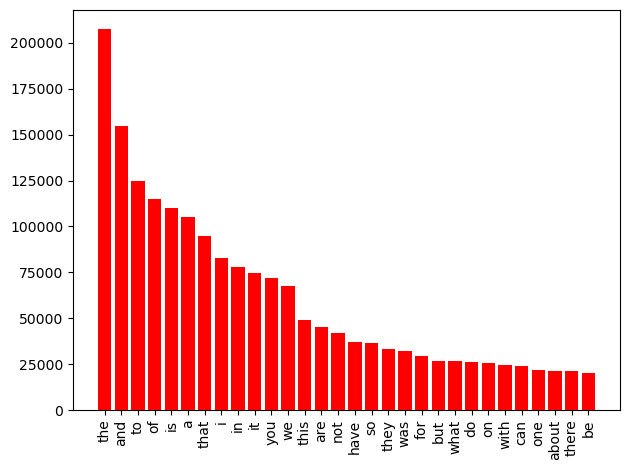

In [62]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000][:mostfreqn]
indices = np.arange(len(counts_ted_top1000[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

Exercise: You can clearly see, that many of the most common words are redundant and not very meaningful. These types of words are called **stopwords**. What problems can stop words create in the NLP and why it is important to remove them?

**Your answer goes here:**

Stopwords add a lot of noise, meaning they increase the amount of text that needs to be processed without adding much meaningful information. This can make it harder for an NLP model to identify the important parts of the text.  

Stopwords add a lot of noise, meaning they increase the amount of text that needs to be processed without adding much meaningful information. This can make it harder for an NLP model to identify the important parts of the text.  

Stopwords could possibly dilute the importance of more informative words. The might affect the quality and performance of the model, as they do not help in distinguishing the actual content or context.

<h4>Exercise 2.2 (2 Points)</h4>

Now, write a function that removes the stopwords from the variable `counts_ted_top1000` and save it as `counts_ted_top1000_no_stopword`. Use the code for visualization and spot the differences.

The structure in the end should look like this: counts_ted_top1000_no_stopword = [(WordA,FrequencyA),(WordB,FrequencyB)]

In [63]:
# Your code goes here

# lets use the nltk stop stop words.
# Download stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

def get_stopwords():
    return set(stopwords.words('english'))

def remove_stopwords_from_counts(counts):
    """
    Removes stopwords from the list of word-frequency tuples.
    """
    stop_words = get_stopwords()
    return [(word, freq) for word, freq in counts if word.lower() not in stop_words]

# Remove stopwords from the list of word-frequency tuples
counts_ted_top1000_no_stopword = remove_stopwords_from_counts(counts_ted_top1000)
print(counts_ted_top1000_no_stopword)


[('one', 21953), ('people', 16269), ('like', 16025), ('would', 14002), ('know', 11469), ('going', 11451), ('us', 11054), ('think', 10455), ('see', 10162), ('really', 9672), ('get', 9370), ('two', 8787), ('time', 8540), ('world', 8278), ('could', 8105), ('actually', 8009), ('way', 7679), ('years', 7558), ('things', 7542), ('hundred', 7277), ('want', 7133), ('go', 7126), ('make', 6788), ('well', 6653), ('said', 6343), ('right', 6321), ('something', 6301), ('first', 6151), ('much', 5894), ('also', 5694), ('look', 5669), ('new', 5546), ('got', 5536), ('thing', 5531), ('little', 5490), ('back', 5326), ('say', 5267), ('even', 5212), ('work', 5102), ('life', 4956), ('many', 4924), ('need', 4922), ('take', 4896), ('thousand', 4745), ('kind', 4554), ('lot', 4543), ('around', 4446), ('good', 4442), ('every', 4391), ('different', 4293), ('three', 4269), ('let', 4231), ('come', 3966), ('use', 3755), ('put', 3608), ('day', 3601), ('called', 3374), ('percent', 3328), ('made', 3243), ('today', 3202),

[nltk_data] Downloading package stopwords to /home/alec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


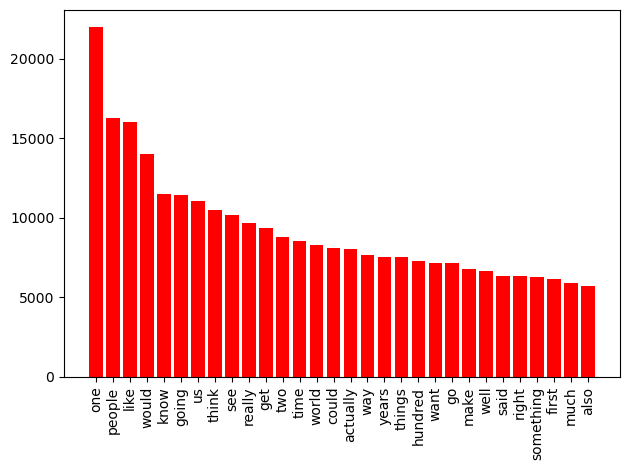

In [64]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
indices = np.arange(len(counts_ted_top1000_no_stopword[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

#### Wordcloud Visualization

The below so-called **wordcloud** shows the most frequent words in a larger font and the less frequent ones in a smaller font size. It's a quick and cool way of visualizing the most frequent words!

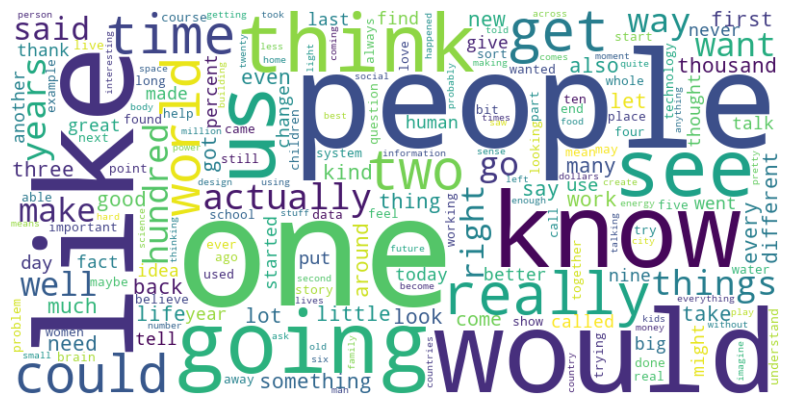

In [65]:
# Create a dictionary that maps words to their frequencies
counts_ted_top1000_no_stopword = {word: count for word, count in counts_ted_top1000_no_stopword}

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
wordcloud.generate_from_frequencies(counts_ted_top1000_no_stopword)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Part 3: Generating the Word Embeddings with Word2Vec

Now it is time to run the embedding model. Gensim has an already implemented model that you can use. Using the provided model is enough for the purposes of our notebook. If you want to dive deeper into the topic - this youtube video https://www.youtube.com/watch?v=kKDYtZfriI8 could be a great guidance for you to get started.

In [66]:
# This takes a moment.. dont worry :D
from gensim.models import Word2Vec

model_ted = Word2Vec(sentences_ted)


### Part 4: Inspection of our learned representations/embeddings (3 Points)


Now that we have a model that captures the word embeddings, we can use it to explore properties of the words in the text.

First, code a line that looks at the embedding of one individual word/token.  What does the representation of "house" look like in the embedding model? You may refer to the following gensim docs for functions, that might help you https://radimrehurek.com/gensim/models/keyedvectors.html). This will give you 1 point.

In [72]:
# Your solution goes here.

# Get embedding for a specific word
token = "house"
if token in model_ted.wv:
    embedding = model_ted.wv[token]
    print(f"Embedding for '{token}': {embedding}")
else:
    print(f"Token '{token}' not found in the vocabulary.")

Embedding for 'house': [ 0.7114914  -0.370726    0.6909064  -2.5485308   0.11862645  0.02088797
  1.0550587   1.2578961  -0.64262545  0.48839563  1.3162441  -0.09901477
 -0.35542983  0.2128953  -0.27971655 -0.68050814  0.81692576  0.44445303
 -0.54452634  0.70362335  1.097598   -1.4971181   0.15013522 -1.7405386
  0.72679985 -0.2745198   1.6783065  -1.6444346  -0.0907947  -0.28581032
  0.4053605   1.1577688  -1.1583425  -0.18983288  0.5012375  -1.2863516
  0.0122676   0.04002262 -0.11343571 -0.97162396  1.1552129   0.18143325
  1.1610434   1.2459999  -1.295957   -0.91190773 -1.4086537   1.1888477
  0.9075374  -0.84910476 -0.6112916  -0.06469995 -0.93597305 -0.27936673
 -1.2340904   1.5678217  -0.04092101  1.0524738   0.94468796  0.49540043
  1.1803778  -0.30155936  1.4326583   0.05178016 -0.52923506  0.21116617
  0.14439009  0.48495674  0.31221855  0.89259475 -0.28032634 -0.49504012
 -1.5465429  -0.69682753  0.3171825   0.20751758  0.7556524  -1.1677045
 -0.7870932  -0.1424833   0.7216

The next task for you is to output the most similar word to "town"? This will also give you 1 point.

In [68]:
# Your solution goes here.

# Get most similar word to "town"
most_similar = model_ted.wv.most_similar("town", topn=1)
print(f"Most similar word to 'town': {most_similar[0]}")

Most similar word to 'town': ('village', 0.893972635269165)


Finally, we want to find out how similar the words "town" and "house" are. Again: 1 point for this!

In [69]:
# Your solution goes here.

#  Calculate similarity between "town" and "house"
similarity = model_ted.wv.similarity("town", "house")
print(f"Similarity between 'town' and 'house': {similarity}")


Similarity between 'town' and 'house': 0.7356417179107666


<h4>Exercise 4.1 (3 Points)</h4>


Now that we have generated our embeddings, let's test some classical ideas:
implement the following formula. Print out the 10 words, that are most similar to this formula: <br>
$King-Man+Woman=???$
There are two ways of computing similarity in word embeddings:
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar_cosmul.html
You should try out both! In this case one of them is better, but both of them are valid methods for computing similarity in the word-space.

In [73]:
# Your implementation goes here.

# Calculate most similar words to the formula: King - Man + Woman
most_similar_cosine = model_ted.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=10)
print("Using cosine-similarity:")
for word, score in most_similar_cosine:
    print(f"{word}: {score}")


most_similar_cosmul = model_ted.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'], topn=10)
print("\nUsing cosmul:")
for word, score in most_similar_cosmul:
        print(f"{word}: {score}")

Using cosine-similarity:
martin: 0.7766596078872681
president: 0.7744805812835693
luther: 0.7708251476287842
james: 0.7586084008216858
obama: 0.7490222454071045
named: 0.7359910011291504
charles: 0.7343780994415283
dr: 0.7325577735900879
french: 0.7323524355888367
mayor: 0.7241443395614624

Using cosmul:
president: 0.9276400208473206
martin: 0.9263147711753845
luther: 0.9229316115379333
james: 0.9151915311813354
obama: 0.9135901927947998
named: 0.9073943495750427
french: 0.9031094908714294
dr: 0.903104305267334
charles: 0.9024608731269836
queen: 0.9012247323989868


Exercise 4.2 (2 Points)

The expected outcome (Queen) should be one of the top ten most similar words. But there are also a lot of words, that you would not expect. Think about where how these words might be connected to the formula. Take your time and understand why some of the words (luther, mary, dr, president) might be in this list.

**Your answer goes here:**

Data Bias:
Our model was trained on the TED talk data, which might not have the same associations that are present in larger and more diverse datasets. The embeddings are heavily influenced by the training data, so they may not have learned the same kind of cultural or semantic relationships, like "king" being related to "queen."  

Training Data Size:  
The dataset we're using is relatively small compared to the corpora used to train standard embeddings like Word2Vec. Small datasets often result in less representative word relationships.  

Word Frequency and Context:  
Words like "luther" and "french" might appear in contexts that have some similarities to "king" and "woman" in our dataset, based on the limited data we have. This means that "king" - "man" + "woman" results in a vector pointing to a word that is statistically similar to those found in similar contexts.

#### t-SNE visualization

We will use the t-SNE algorithm, given below, for visualization. The so-called t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised and non-linear machine learning technique. It is commonly used for visualizing high dimensional data (just like our high dimensional vectors). You do not have to understand the code, its purpose is simply to give you an idea of how the data is arranged in high dimensional space.

<h4>Exercise 4.3 (2 Points)</h4>

To use the t-SNE code below, first put a list of the top 50 words (as **strings**, without **stopwords**) into a variable `words_top_ted`.

In [74]:
# Your implementation goes here.

# Get the top 50 words without stopwords
# Remove stopwords from the list of word-frequency tuples
counts_ted_top1000_no_stopword = remove_stopwords_from_counts(counts_ted_top1000)

words_top_ted = [word for word, freq in counts_ted_top1000_no_stopword[:50]]
print(words_top_ted)

['one', 'people', 'like', 'would', 'know', 'going', 'us', 'think', 'see', 'really', 'get', 'two', 'time', 'world', 'could', 'actually', 'way', 'years', 'things', 'hundred', 'want', 'go', 'make', 'well', 'said', 'right', 'something', 'first', 'much', 'also', 'look', 'new', 'got', 'thing', 'little', 'back', 'say', 'even', 'work', 'life', 'many', 'need', 'take', 'thousand', 'kind', 'lot', 'around', 'good', 'every', 'different']


The following code gets the corresponding vectors from the model, assuming it's called `model_ted`:

In [75]:
# This assumes words_top_ted is a list of strings, the top 250 words
words_top_vec_ted = model_ted.wv[words_top_ted]

The next few lines are for the t-SNE visualization.

In [76]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

In [77]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_top_ted))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

That's it. We hope you had fun and learned something in the process :-)